# Workflow:
#### 1. Starting off with built-in functionality
#### 2. Writing your own metrics
#### 3. Using callbacks
#### 4. Monitoring and visualising using TensorBoard
#### 5. Writing custom training and evaluation loops


# 1. Starting off with a model using built-in training and evaluation loops

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# function to create model
# using functional API ? lol
def get_minst_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

2023-03-15 15:32:59.319062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# loading data
(images, labels), (test_images, test_labels) = mnist.load_data()

# reshaping and normalising data
images = images.reshape((60000, 28*28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255

# splitting data
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

# creating, compiling, fitting model
# targets are in the form of integers (not one hot encoded), so use sparse categorical
model = get_minst_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

2023-03-15 15:34:06.814205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 15:34:06.838671: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/3
1563/1563 [==============================] - 22s 13ms/step - loss: 0.2894 - accuracy: 0.9142 - val_loss: 0.1460 - val_accuracy: 0.9585
Epoch 2/3
1563/1563 [==============================] - 19s 12ms/step - loss: 0.1654 - accuracy: 0.9542 - val_loss: 0.1253 - val_accuracy: 0.9660
Epoch 3/3
313/313 [==============================] - 1s 4ms/step


In [3]:
test_metrics

[0.10734552890062332, 0.9714999794960022]

# 2. Writing your own metrics
A Keras metric is a subclass of the *keras.metrics.Metric* class. Like layers, a met-
ric has an internal state stored in TensorFlow variables. Unlike layers, these variables
aren’t updated via backpropagation, so you have to write the state-update logic your-
self, which happens in the *update_state()* method.

Let's build a custom metric that measures root mean squared error

To do so you have to override the update_state, result, and reset_state functions:

**update_state()** does all the updates to state variables and calculates the metric,

**result()** returns the value for the metric from state variables,


**reset_state()** sets the metric value at the beginning of each epoch to a predefined constant (typically 0)

**kwargs** - additional layer keyword arguments

**add_weights** - provides a shortcut to create weights

In [4]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    # define state variables in this constructor
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        # creating weights to hold mse sum
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        # creating weight to hold total no of samples
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")
    
    # overriding method to update state
    # the state variables are updated after each batch
    # so assign add computed values to existing states after each batch to get final values
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth = tf.shape(y_pred)[1])
        # computing metrics and updating the state variables
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
    
    # method to return current values of metrics
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    # method to reset metric state without reinstantiating it
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [6]:
# using our built in metric
model = get_minst_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3,
         validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 20s 13ms/step - loss: 0.2971 - accuracy: 0.9115 - rmse: 7.1819 - val_loss: 0.1521 - val_accuracy: 0.9572 - val_rmse: 7.3593
Epoch 2/3
1563/1563 [==============================] - 19s 12ms/step - loss: 0.1649 - accuracy: 0.9542 - rmse: 7.3546 - val_loss: 0.1284 - val_accuracy: 0.9678 - val_rmse: 7.4042
Epoch 3/3
313/313 [==============================] - 2s 5ms/step - loss: 0.1184 - accuracy: 0.9709 - rmse: 7.4347


In [7]:
test_metrics
# [loss, accuracy, rmse]

[0.11844365298748016, 0.9708999991416931, 7.434699058532715]

# 3. Using Callbacks

A callback is an object (a class instance implementing specific methods) that is
passed to the model in the call to fit() and that is called by the model at various
points during training. It has access to all the available data about the state of the
model and its performance, and it can take action: interrupt training, save a model,
load a different weight set, or otherwise alter the state of the model.

## 3.1 Built in early-stopping callback

The EarlyStopping callback interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs

In [8]:
# callbacks are passed on as a list when fitting model
callbacks_list = [
    
    # interrupt training when val accuracy hasn't improved for 2 epochs
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience = 2
    ),
    
    # saves current weights after every epoch
    # don't overwrite file unless val loss has improved
    keras.callbacks.ModelCheckpoint(
        filepath = "checkpoint_path.keras",
        monitor = "val_loss",
        save_best_only = True
    )
]


model = get_minst_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics = ["accuracy"])
model.fit(train_images, train_labels,
         epochs=10,
         callbacks=callbacks_list,
         validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.2948 - accuracy: 0.9122 - val_loss: 0.1465 - val_accuracy: 0.9582
Epoch 2/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.1696 - accuracy: 0.9525 - val_loss: 0.1201 - val_accuracy: 0.9668
Epoch 3/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.1386 - accuracy: 0.9625 - val_loss: 0.1101 - val_accuracy: 0.9704
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1286 - accuracy: 0.9669 - val_loss: 0.1066 - val_accuracy: 0.9731
Epoch 5/10
1563/1563 [==============================] - 16s 11ms/step - loss: 0.1160 - accuracy: 0.9715 - val_loss: 0.1021 - val_accuracy: 0.9776
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1077 - accuracy: 0.9738 - val_loss: 0.1078 - val_accuracy: 0.9772
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1062 - accuracy: 0.9749 - val_loss: 0.1162 - v

## 3.2 Building your own callbacks

Following are the methods you can use:

- on_epoch_begin(epoch, logs)

- on_epoch_end(epoch, logs)

- on_batch_begin(batch, logs)

- on_batch_end(batch, logs)

- on_train_begin(logs)

- on_train_end(logs)

These methods are all called with a logs argument, which is a dictionary containing
information about the previous batch, epoch, or training run

In [16]:
# creating callback to save a list of per-batch loss values
# save a grpah of these values at the end of each epoch

import matplotlib.pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
    
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
        
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"images/plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.2907 - accuracy: 0.9134 - val_loss: 0.1442 - val_accuracy: 0.9601
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1635 - accuracy: 0.9540 - val_loss: 0.1199 - val_accuracy: 0.9677
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1386 - accuracy: 0.9630 - val_loss: 0.1086 - val_accuracy: 0.9716
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1237 - accuracy: 0.9678 - val_loss: 0.1133 - val_accuracy: 0.9733
Epoch 5/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1134 - accuracy: 0.9713 - val_loss: 0.1093 - val_accuracy: 0.9745
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1100 - accuracy: 0.9737 - val_loss: 0.1097 - val_accuracy: 0.9768
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1066 - accuracy: 0.9744 - val_loss: 0.1060 - 

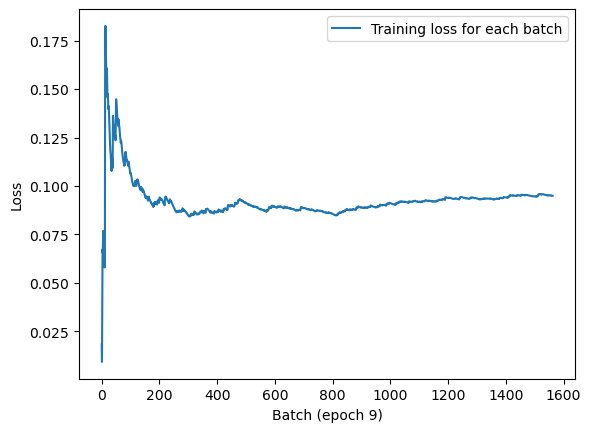

In [17]:
model = get_minst_model()
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels,
        epochs=10,
        callbacks=[LossHistory()],
        validation_data=(val_images, val_labels))

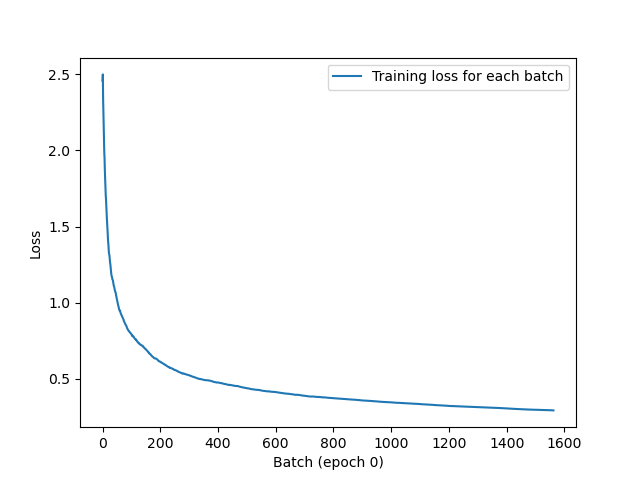

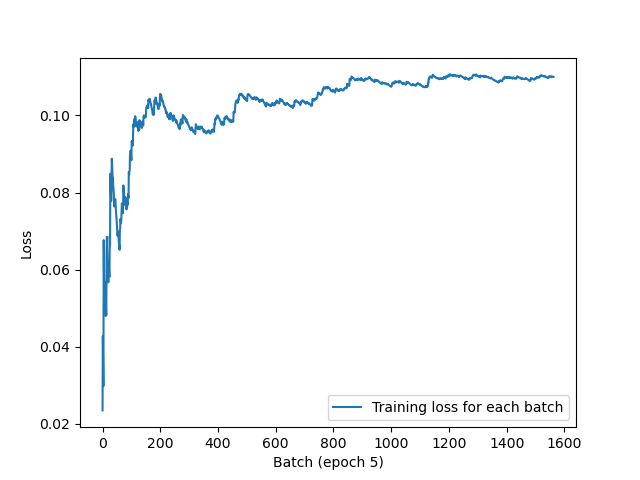

# 4. Monitoring and visualization with TensorBoard

The easiest way to use TensorBoard with a Keras model and the fit() method is to
use the keras.callbacks.TensorBoard callback.

In [23]:
model = get_minst_model()
model.compile(optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(
        log_dir="log/",
    )
model.fit(train_images, train_labels,
        epochs=10,
        validation_data=(val_images, val_labels),
        callbacks=[tensorboard]
         )

Epoch 1/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.2935 - accuracy: 0.9138 - val_loss: 0.1493 - val_accuracy: 0.9580
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1642 - accuracy: 0.9542 - val_loss: 0.1236 - val_accuracy: 0.9677
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1416 - accuracy: 0.9635 - val_loss: 0.1156 - val_accuracy: 0.9704
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1296 - accuracy: 0.9669 - val_loss: 0.1073 - val_accuracy: 0.9727
Epoch 5/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1188 - accuracy: 0.9706 - val_loss: 0.0985 - val_accuracy: 0.9756
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1075 - accuracy: 0.9735 - val_loss: 0.1128 - val_accuracy: 0.9762
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1086 - accuracy: 0.9740 - val_loss: 0.1137 - va

In [27]:
%load_ext tensorboard
%tensorboard --logdir log/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 5. Writing custom training and evaluation loops

## 5.1 A general supervised learning step (custom training)

In [28]:
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # specify training=True since some layers have diff behaviours with training and not
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
        
        # specify trainable weights - weights modified during backprop
        gradients = tape.gradients(loss, model.trainable_weights)
        optimzer.apply_gradients(zip(model.trainable_weights, gradients))

## 5.2 Low-level usage of metrics (custom evaluation)

In a low-level training loop, you will probably want to leverage Keras metrics (whether
custom ones or the built-in ones). You’ve already learned about the metrics API: simply call update_state(y_true, y_pred) for each batch of targets and predictions, and then use result() to query the current metric value:

In [30]:
# call metric
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# update states to get current metric value
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

values = [0, 1, 2, 3, 4]

# can also track the average of a scalar value
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

result: 1.00
Mean of values: 2.00


## 5.3 A complete trianing and evaluation loop

In [37]:
model = get_minst_model()

# define everything
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

# create forward loop
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

In [38]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

In [39]:
training_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9136
...loss: 0.2905
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9546
...loss: 0.1633
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9623
...loss: 0.1415


In [41]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
        loss_tracking_metric.update_state(loss)
        logs["val_loss"] = loss_tracking_metric.result()
        return logs
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9672
...val_loss: 0.1282


## 5.4 Make it fast with tf.function

In [42]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9672
...val_loss: 0.1282


## 5.5 Leveraging fit() with a custom training loop

What if you need a custom training algorithm, but you still want to leverage the
power of the built-in Keras training logic? There’s actually a middle ground between
fit() and a training loop written from scratch

You can do this by overriding the train_step() method of the Model class. This is
the function that is called by fit() for every batch of data. You will then be able to call
fit() as usual, and it will be running your own learning algorithm under the hood.

Steps:
- create a new subclass of keras.Model
- override train_step method
- implement metrics property

In [43]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}
    
    @property
    def metrics(self):
        return [loss_tracker]

In [44]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2978
Epoch 2/3
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1663
Epoch 3/3
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1403


In [47]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [48]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop(),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 17s 11ms/step - loss: 0.2907 - sparse_categorical_accuracy: 0.9131
Epoch 2/3
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9530
Epoch 3/3
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1401 - sparse_categorical_accuracy: 0.9622
